## Fine-tune a linear classification head for DINOv2 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import VisionDataset
from torch.utils.data import DataLoader, Subset
import torchvision.models

Hardware and training configurations

In [27]:
train_dir = f"/workspace/geopacha/data/region1_data/train"
test_dir = f"/workspace/geopacha/data/region1_data/test"
val_dir = f"/workspace/geopacha/data/region1_data/valid"
working_dir = f"/workspace/geopacha/jn"
num_workers = 0
batch_size = 8
n_epochs = 10
learning_rate = 0.0001
max_epochs_stop = 3
print_every = 1

## Configure ImageDataset

### Image transformations

In [28]:
image_transformations = {
    'train': transforms.Compose([
        torchvision.transforms.Resize(size=(196, 196), antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        torchvision.transforms.Resize(size=(196, 196), antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        torchvision.transforms.Resize(size=(196, 196), antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### ImageDataset class

In [29]:
class GeoPACHAImageDataset(VisionDataset):
    def __init__(self, data_dir, data_file, transform=None):
        super().__init__(root=data_dir, transform=transform)  # Initialize the base VisionDataset
        self.data_dir = data_dir
        df = pd.read_csv(data_file, delimiter=",")
        self.image_paths = df['img_path']
        self.labels = df['label']
        self.transform = transform

        # Create the class_to_idx dictionary
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(self.labels.unique()))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        # Load image
        image = np.load(img_path)
        # If image has more than 3 channels, take only the first 3 channels (RGB)
        if image.shape[0] > 3:
            image = image[:3]
        # Convert image to tensor
        image = torch.from_numpy(image)
        if self.transform:
            image = self.transform(image)
        # Get label and convert to index using class_to_idx
        label = self.class_to_idx[self.labels[idx]]
        # label = self.labels[idx]

        return image, label


In [30]:
datasets = {
    'train': GeoPACHAImageDataset(data_dir=train_dir, data_file='/workspace/geopacha/data/region1_data/train_clean.csv', transform=image_transformations['train']),
    'test': GeoPACHAImageDataset(data_dir=test_dir, data_file='/workspace/geopacha/data/region1_data/test_clean.csv', transform=image_transformations['test']),
    'validation': GeoPACHAImageDataset(data_dir=val_dir, data_file='/workspace/geopacha/data/region1_data/valid_clean.csv', transform=image_transformations['validation'])
}

#### Check custom ImageDataset

Check images from GeoPACHAImageDataset against direct image import

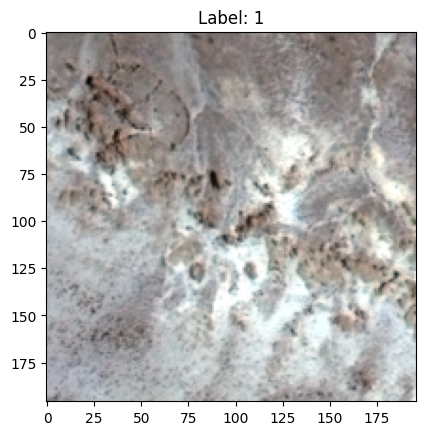

In [7]:
import matplotlib.pyplot as plt
import torch

image, label = datasets['train'][0]

# Reverse normalization applied in transformation for visualization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

if image.dim() == 3:  # C, H, W
    image = image.permute(1, 2, 0)  # Convert to H, W, C for matplotlib

image = image * std + mean  # denormalize
# image = image.clip(0, 1)  # ensure the image values are between 0 and 1

image
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()


### Dataloader

In [31]:
dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'validation': torch.utils.data.DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

In [17]:
def imshow_tensor(image, title=None, size=(24, 24)):
    """
    Imshow for Tensor.
    
    Parameters:
        image (torch.Tensor): The image tensor to display.
        title (str, optional): The title of the plot.
        size (tuple, optional): The figure size in inches.
    """
    
    # Ensure the input image tensor is for image data
    if image.dim() == 4 and image.size(0) == 1:
        image = image.squeeze(0)  # Squeeze the tensor if it contains an extra batch dimension

    # Check if the tensor is on GPU and move to CPU
    if image.is_cuda:
        image = image.cpu()

    # Convert to numpy and adjust the channel order
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip values to ensure they're within [0, 1] since imshow expects this range
    image = np.clip(image, 0, 1)

    # Create a figure with the specified size
    plt.figure(figsize=size)

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

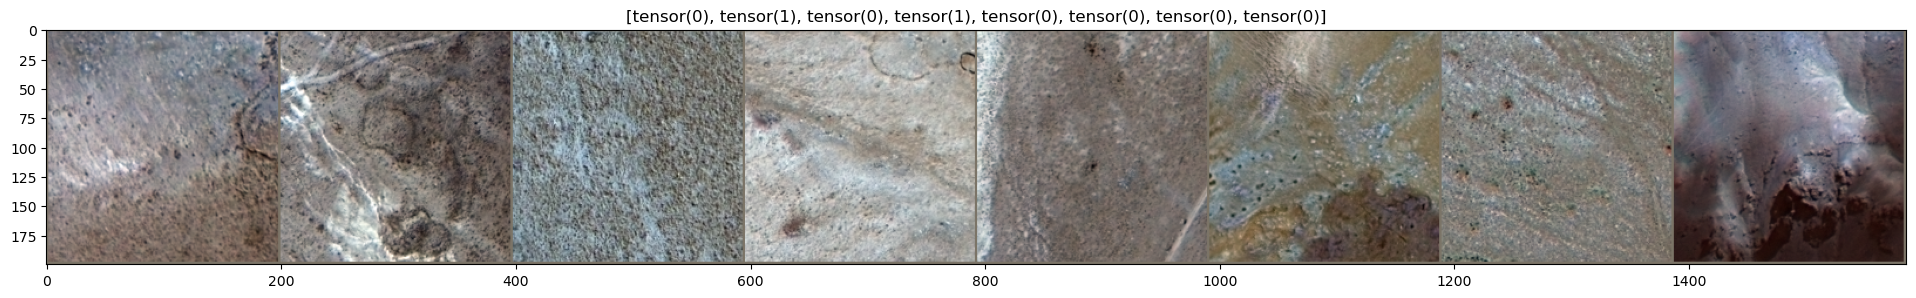

tensor(0) tensor(1) tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0)


In [18]:
# get some random training images
images, labels = iter(trainiter).__next__()

grid = torchvision.utils.make_grid(images)

# show images
imshow_tensor(grid, title=[x for x in labels])
# print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

## Load pretrained DINOv2 model for linear classification

In [32]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_lc', pretrained=True)

print("Confirm object type: ", type(model))

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Confirm object type:  <class 'dinov2.hub.classifiers._LinearClassifierWrapper'>


#### Check model layers

In [20]:
print(model)

_LinearClassifierWrapper(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inpl

### Prepare layers for fine-tuning

Freeze all pretrained layers except the classification head

In [33]:
# Freeze all layers except the classification head
for name, param in model.named_parameters():
    if 'linear_head' not in name:  
        param.requires_grad = False

# check if all parameters are frozen except the heads
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} trainable: {param.requires_grad}")

linear_head.weight trainable: True
linear_head.bias trainable: True


In [34]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

309,489,640 total parameters.
5,121,000 training parameters.


In [35]:
model.linear_head.in_features = 1024
model.linear_head.out_features = 2
model.linear_head

Linear(in_features=1024, out_features=2, bias=True)

In [36]:
model.class_to_idx = datasets['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [38]:
# Sanity check if NaNs are present in the model
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"NaNs in {name}")

In [46]:
def reset_training_experiment(alpha):
    # Reload the model and optimizer
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_lc', pretrained=True)
    model.class_to_idx = datasets['train'].class_to_idx
    model.idx_to_class = {
        idx: class_
        for class_, idx in model.class_to_idx.items()
    }
    # Freeze all layers except the classification head
    for name, param in model.named_parameters():
        if 'linear_head' not in name:  
            param.requires_grad = False

    # check if all parameters are frozen except the classification head
    for name, param in model.named_parameters():
        if param.requires_grad and 'linear_head' not in name:
            print(f"ERROR - {name} trainable: {param.requires_grad}")
    
    model.linear_head.in_features = 1024
    model.linear_head.out_features = 2

    model.class_to_idx = datasets['train'].class_to_idx
    model.idx_to_class = {
        idx: class_
        for class_, idx in model.class_to_idx.items()
    }
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=alpha)
    # Sanity check if NaNs are present in the model
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"ERROR - NaNs in {name}")

    model = model.cuda()  # Move the model to GPU
    model.train()
    
    return model, criterion, optimizer

In [41]:
torch.cuda.empty_cache()

## Finetune

### Finetune 100 Epochs and Batch Size = 64

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Starting Training.

Starting finetuning...
train epoch[1/100] loss:0.737: 100%|██████████| 25/25 [00:04<00:00,  5.54it/s]
Starting validation loop...

Epoch: 1 	Training Loss: 3.2722 \Validation Loss: 0.6512
		Training Accuracy: 34.13%	 Validation Accuracy: 68.96%
Starting finetuning...
train epoch[2/100] loss:0.579: 100%|██████████| 25/25 [00:04<00:00,  5.49it/s]
Starting validation loop...

Epoch: 2 	Training Loss: 0.6718 \Validation Loss: 0.6436
		Training Accuracy: 65.62%	 Validation Accuracy: 66.88%
Starting finetuning...
train epoch[3/100] loss:0.604: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s]
Starting validation loop...

Epoch: 3 	Training Loss: 0.5094 \Validation Loss: 0.5559
		Training Accuracy: 75.08%	 Validation Accuracy: 71.36%
Starting finetuning...
train epoch[4/100] loss:0.479: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]
Starting validation loop...

Epoch: 4 	Training Loss: 0.4481 \Validation Loss: 0.4642
		Training Accuracy: 78.15%	 Validation Accuracy: 76.40%


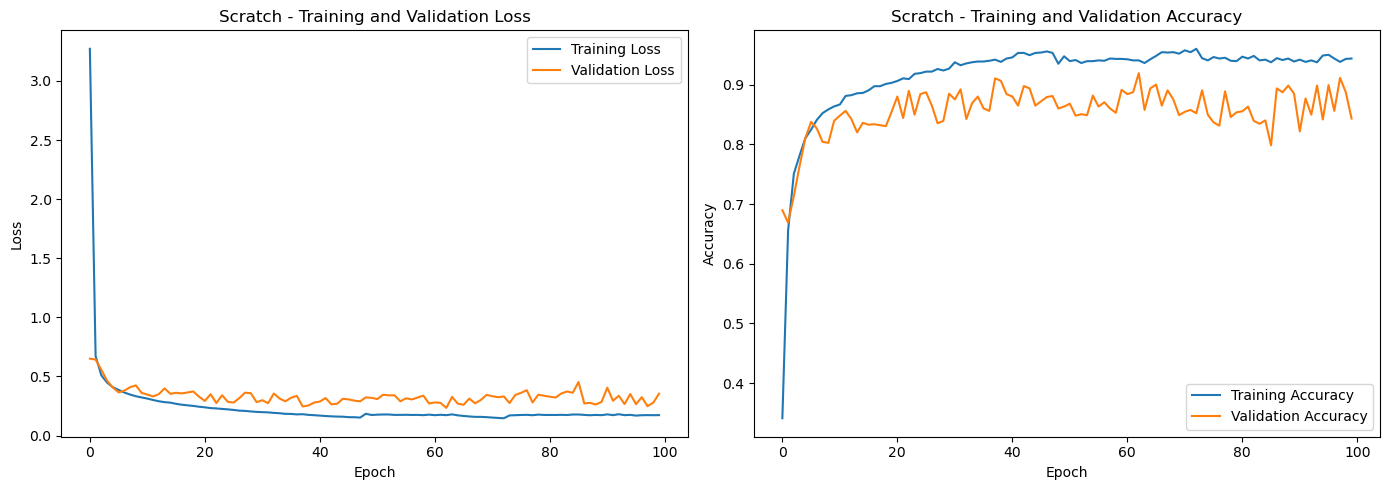

In [50]:

batch_size = 64

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'validation': torch.utils.data.DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
}

model, criterion, optimizer = reset_training_experiment(alpha=0.0001)

n_epochs = 100
save_model_file_name = f'{working_dir}/model/dinov2_vitl14_lc_state_dict_{n_epochs}_epoch_test_batch_size{batch_size}.pth'

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf
valid_max_acc = 0
max_epochs_stop = 10
history = []

# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training.\n')

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()
# Run a training loop
for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0
    valid_acc = 0
    counter = 1

    model.train()
    print("Starting finetuning...")
    train_bar = tqdm(dataloaders['train'], file=sys.stdout)
    # progress_bar = tqdm(range(len(dataloaders['train'])))
    for ii, (data, target) in enumerate(train_bar):
    # for data, target in dataloaders['train']:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        if torch.isnan(data).any():
            print(f"Data contains NaNs")
        elif torch.isnan(output).any():
            print(f"Output contains NaNs (counter={counter})")
        else:
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Calculate the training loss
            train_loss += loss.item() * data.size(0)
            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

        train_bar.update(1)
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     n_epochs,
                                                                     loss)
        counter += 1

    # After training loops ends, start validation
    else:
        model.epochs += 1
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            # Validation loop
            print("Starting validation loop...")
            for data, target in dataloaders['validation']:
                data, target = data.cuda(), target.cuda()
                if torch.isnan(data).any():
                    print(f"Data contains NaNs")
                else:
                    # Forward pass
                    output = model(data)
                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(dataloaders['train'].dataset)
            valid_loss = valid_loss / len(dataloaders['validation'].dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(dataloaders['train'].dataset)
            valid_acc = valid_acc / len(dataloaders['validation'].dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch + 1} \tTraining Loss: {train_loss:.4f} \Validation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')
            
            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_model_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch
            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                    )
                    # Load the best state dict
                    model.load_state_dict(torch.load(save_model_file_name))

                    # Attach the optimizer
                    model.optimizer = optimizer
            

end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)

print("") 
print("Inferencing complete.")
print("Elapsed time: ", elapsed_time_ms)

# Save the model
torch.save(model.state_dict(), save_model_file_name)

# Format history
history_df = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

# Save the history object to a pickle file
history_filename = f'{working_dir}/model/training_history_dinov2_vitl14_lc_100_epoch_test_batch_size{batch_size}.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history_df, f)

print(f'Training history saved to {history_filename}')

f_name = f"dinov2_vitl14_lc_{n_epochs}_epoch_test_batch_size{batch_size}.png"
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Training Loss')
plt.plot(history_df['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Scratch - Training and Validation Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Training Accuracy')
plt.plot(history_df['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Scratch - Training and Validation Accuracy')
plt.legend()

# Save the plot to a file
plt.tight_layout()
plt.savefig(f'{working_dir}/output/{f_name}')
plt.show()

## Increase Batch Size

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Starting Training.

Class 0 - Train Accuracy: 0.66, Validation Accuracy: 0.76
Class 1 - Train Accuracy: 0.70, Validation Accuracy: 0.78
Epoch 1: Total Train Acc: 0.68, Total Valid Acc: 0.76
Training Loss: 0.9446, Validation Loss: 0.5027

Epoch: 1 	Training Loss: 1508.4792 	Validation Loss: 628.3832
		Training Accuracy: 67.94%	 Validation Accuracy: 76.48%
Class 0 - Train Accuracy: 0.85, Validation Accuracy: 0.83
Class 1 - Train Accuracy: 0.81, Validation Accuracy: 0.74
Epoch 2: Total Train Acc: 0.83, Total Valid Acc: 0.82
Training Loss: 0.3846, Validation Loss: 0.3902

Epoch: 2 	Training Loss: 614.2390 	Validation Loss: 487.7170
		Training Accuracy: 82.97%	 Validation Accuracy: 82.08%
Class 0 - Train Accuracy: 0.87, Validation Accuracy: 0.76
Class 1 - Train Accuracy: 0.85, Validation Accuracy: 0.84
Epoch 3: Total Train Acc: 0.86, Total Valid Acc: 0.77
Training Loss: 0.3288, Validation Loss: 0.4905

Epoch: 3 	Training Loss: 525.1496 	Validation Loss: 613.1565
		Training Accuracy: 85.97%	

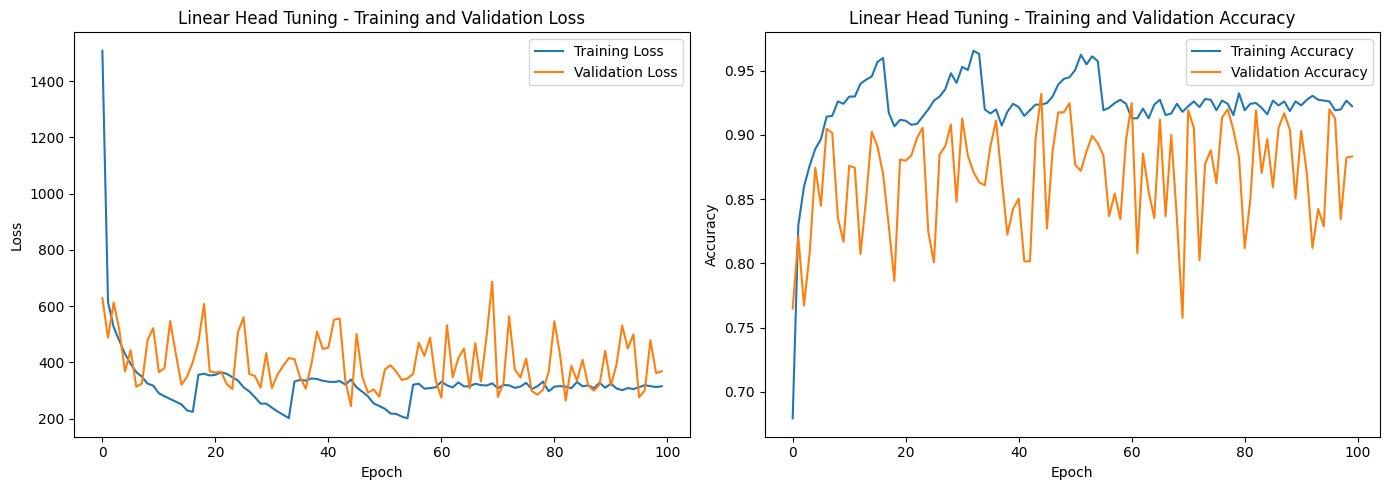

In [43]:
import numpy as np
from collections import defaultdict
import torch
from torch import nn, optim
from tqdm import tqdm
import sys

model, criterion, optimizer = reset_training_experiment(alpha=0.0001)

n_epochs = 100
num_classes = 2

# Initialize dictionaries to track per-class metrics
class_correct_train = {i: 0 for i in range(num_classes)}
class_total_train = {i: 0 for i in range(num_classes)}
class_correct_valid = {i: 0 for i in range(num_classes)}
class_total_valid = {i: 0 for i in range(num_classes)}

learning_rate = 0.0001
batch_size = 128
# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf
valid_max_acc = 0
max_epochs_stop = 10
history = []
save_model_file_name = f'/workspace/geopacha/jn/model/dinov2_vitl14_lc_state_dict_{n_epochs}e_{batch_size}b.pt'
# save_model_file_name = f'TEST.pth'

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training.\n')

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

model.cuda()

for epoch in range(n_epochs):
    # Reset training and validation metrics at the start of each epoch
    train_loss, valid_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0
    class_correct_train = {i: 0 for i in range(num_classes)}
    class_total_train = {i: 0 for i in range(num_classes)}
    class_correct_valid = {i: 0 for i in range(num_classes)}
    class_total_valid = {i: 0 for i in range(num_classes)}

    model.train()
    for data, target in dataloaders['train']:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        for i in range(num_classes):
            correct = (preds == target)
            class_correct_train[i] += correct[target == i].sum().item()
            class_total_train[i] += (target == i).sum().item()

    # Validation phase
    model.eval()
    with torch.no_grad():
        for data, target in dataloaders['validation']:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            for i in range(num_classes):
                correct = (preds == target)
                class_correct_valid[i] += correct[target == i].sum().item()
                class_total_valid[i] += (target == i).sum().item()

    # Calculate and print per-class accuracies
    train_acc_class_0 = (class_correct_train[0] / class_total_train[0]) if class_total_train[0] > 0 else 0
    valid_acc_class_0 = (class_correct_valid[0] / class_total_valid[0]) if class_total_valid[0] > 0 else 0
    print(f'Class 0 - Train Accuracy: {train_acc_class_0:.2f}, Validation Accuracy: {valid_acc_class_0:.2f}')
    train_acc_class_1 = (class_correct_train[1] / class_total_train[1]) if class_total_train[1] > 0 else 0
    valid_acc_class_1 = (class_correct_valid[1] / class_total_valid[1]) if class_total_valid[1] > 0 else 0
    print(f'Class 1 - Train Accuracy: {train_acc_class_1:.2f}, Validation Accuracy: {valid_acc_class_1:.2f}')


    # Overall metrics for the epoch
    total_train_acc = sum(class_correct_train.values()) / sum(class_total_train.values())
    total_valid_acc = sum(class_correct_valid.values()) / sum(class_total_valid.values())
    print(f'Epoch {epoch + 1}: Total Train Acc: {total_train_acc:.2f}, Total Valid Acc: {total_valid_acc:.2f}')
    print(f'Training Loss: {train_loss/len(dataloaders["train"].dataset):.4f}, Validation Loss: {valid_loss/len(dataloaders["validation"].dataset):.4f}')

    history.append([train_loss, 
                    valid_loss, 
                    total_train_acc, 
                    total_valid_acc, 
                    train_acc_class_0,
                    train_acc_class_1])

    # Print training and validation results
    if (epoch + 1) % print_every == 0:
        print(f'\nEpoch: {epoch + 1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * total_train_acc:.2f}%\t Validation Accuracy: {100 * total_valid_acc:.2f}%')

    # Save the model if validation loss decreases
    if valid_loss < valid_loss_min:
        # Save model
        torch.save(model.state_dict(), save_model_file_name)
        # Track improvement
        epochs_no_improve = 0
        valid_loss_min = valid_loss
        valid_best_acc = valid_acc
        best_epoch = epoch
    # Otherwise increment count of epochs with no improvement
    else:
        epochs_no_improve += 1
        # Trigger early stopping
        if epochs_no_improve >= max_epochs_stop:
            print(
                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
            )
            # Load the best state dict
            model.load_state_dict(torch.load(save_model_file_name))

            # Attach the optimizer
            model.optimizer = optimizer


end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)

print("") 
print("Inferencing complete.")
print("Elapsed time: ", elapsed_time_ms)

# Save the model
torch.save(model.state_dict(), save_model_file_name)

# Format history
history_df = pd.DataFrame(history, columns=['train_loss', 
                                            'valid_loss', 
                                            'train_acc', 
                                            'valid_acc', 
                                            'train_acc_class_0',
                                            'train_acc_class_1'])

# Save the history object to a pickle file
history_filename = f'/workspace/geopacha/jn/model/training_history_dinov2_vitl14_lc_{n_epochs}e_{batch_size}b.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history_df, f)

print(f'Training history saved to {history_filename}')

f_name = f"dinov2_vitl14_lc_{n_epochs}e{batch_size}b.png"
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Training Loss')
plt.plot(history_df['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Head Tuning - Training and Validation Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Training Accuracy')
plt.plot(history_df['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Linear Head Tuning - Training and Validation Accuracy')
plt.legend()

# Save the plot to a file
plt.tight_layout()
plt.savefig(f'{working_dir}/output/{f_name}')
plt.show()

In [44]:
torch.cuda.empty_cache()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Starting Training.

Class 0 - Train Accuracy: 0.66, Validation Accuracy: 0.85
Class 1 - Train Accuracy: 0.68, Validation Accuracy: 0.62
Epoch 1: Total Train Acc: 0.67, Total Valid Acc: 0.82
Training Loss: 0.9079, Validation Loss: 0.3739

Epoch: 1 	Training Loss: 1449.9266 	Validation Loss: 467.3947
		Training Accuracy: 67.25%	 Validation Accuracy: 82.48%
Class 0 - Train Accuracy: 0.85, Validation Accuracy: 0.78
Class 1 - Train Accuracy: 0.81, Validation Accuracy: 0.77
Epoch 2: Total Train Acc: 0.83, Total Valid Acc: 0.78
Training Loss: 0.3814, Validation Loss: 0.4615

Epoch: 2 	Training Loss: 609.1711 	Validation Loss: 576.8310
		Training Accuracy: 82.97%	 Validation Accuracy: 78.00%
Class 0 - Train Accuracy: 0.86, Validation Accuracy: 0.73
Class 1 - Train Accuracy: 0.85, Validation Accuracy: 0.87
Epoch 3: Total Train Acc: 0.86, Total Valid Acc: 0.74
Training Loss: 0.3330, Validation Loss: 0.5296

Epoch: 3 	Training Loss: 531.7375 	Validation Loss: 662.0449
		Training Accuracy: 85.60%	

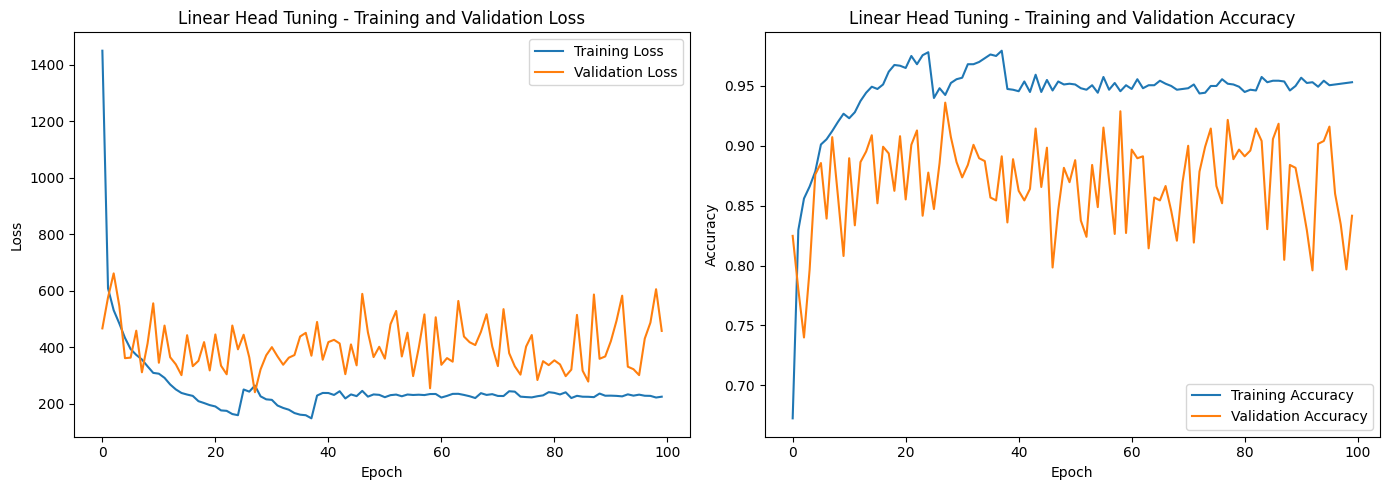

In [45]:
import numpy as np
from collections import defaultdict
import torch
from torch import nn, optim
from tqdm import tqdm
import sys

model, criterion, optimizer = reset_training_experiment(alpha=0.0001)

n_epochs = 100
num_classes = 2

# Initialize dictionaries to track per-class metrics
class_correct_train = {i: 0 for i in range(num_classes)}
class_total_train = {i: 0 for i in range(num_classes)}
class_correct_valid = {i: 0 for i in range(num_classes)}
class_total_valid = {i: 0 for i in range(num_classes)}

learning_rate = 0.0001
batch_size = 196
# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf
valid_max_acc = 0
max_epochs_stop = 10
history = []
save_model_file_name = f'/workspace/geopacha/jn/model/dinov2_vitl14_lc_state_dict_{n_epochs}e_{batch_size}b.pt'
# save_model_file_name = f'TEST.pth'

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training.\n')

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

model.cuda()

for epoch in range(n_epochs):
    # Reset training and validation metrics at the start of each epoch
    train_loss, valid_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0
    class_correct_train = {i: 0 for i in range(num_classes)}
    class_total_train = {i: 0 for i in range(num_classes)}
    class_correct_valid = {i: 0 for i in range(num_classes)}
    class_total_valid = {i: 0 for i in range(num_classes)}

    model.train()
    for data, target in dataloaders['train']:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        for i in range(num_classes):
            correct = (preds == target)
            class_correct_train[i] += correct[target == i].sum().item()
            class_total_train[i] += (target == i).sum().item()

    # Validation phase
    model.eval()
    with torch.no_grad():
        for data, target in dataloaders['validation']:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            for i in range(num_classes):
                correct = (preds == target)
                class_correct_valid[i] += correct[target == i].sum().item()
                class_total_valid[i] += (target == i).sum().item()

    # Calculate and print per-class accuracies
    train_acc_class_0 = (class_correct_train[0] / class_total_train[0]) if class_total_train[0] > 0 else 0
    valid_acc_class_0 = (class_correct_valid[0] / class_total_valid[0]) if class_total_valid[0] > 0 else 0
    print(f'Class 0 - Train Accuracy: {train_acc_class_0:.2f}, Validation Accuracy: {valid_acc_class_0:.2f}')
    train_acc_class_1 = (class_correct_train[1] / class_total_train[1]) if class_total_train[1] > 0 else 0
    valid_acc_class_1 = (class_correct_valid[1] / class_total_valid[1]) if class_total_valid[1] > 0 else 0
    print(f'Class 1 - Train Accuracy: {train_acc_class_1:.2f}, Validation Accuracy: {valid_acc_class_1:.2f}')


    # Overall metrics for the epoch
    total_train_acc = sum(class_correct_train.values()) / sum(class_total_train.values())
    total_valid_acc = sum(class_correct_valid.values()) / sum(class_total_valid.values())
    print(f'Epoch {epoch + 1}: Total Train Acc: {total_train_acc:.2f}, Total Valid Acc: {total_valid_acc:.2f}')
    print(f'Training Loss: {train_loss/len(dataloaders["train"].dataset):.4f}, Validation Loss: {valid_loss/len(dataloaders["validation"].dataset):.4f}')

    history.append([train_loss, 
                    valid_loss, 
                    total_train_acc, 
                    total_valid_acc, 
                    train_acc_class_0,
                    train_acc_class_1])

    # Print training and validation results
    if (epoch + 1) % print_every == 0:
        print(f'\nEpoch: {epoch + 1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * total_train_acc:.2f}%\t Validation Accuracy: {100 * total_valid_acc:.2f}%')

    # Save the model if validation loss decreases
    if valid_loss < valid_loss_min:
        # Save model
        torch.save(model.state_dict(), save_model_file_name)
        # Track improvement
        epochs_no_improve = 0
        valid_loss_min = valid_loss
        valid_best_acc = valid_acc
        best_epoch = epoch
    # Otherwise increment count of epochs with no improvement
    else:
        epochs_no_improve += 1
        # Trigger early stopping
        if epochs_no_improve >= max_epochs_stop:
            print(
                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
            )
            # Load the best state dict
            model.load_state_dict(torch.load(save_model_file_name))

            # Attach the optimizer
            model.optimizer = optimizer


end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)

print("") 
print("Inferencing complete.")
print("Elapsed time: ", elapsed_time_ms)

# Save the model
torch.save(model.state_dict(), save_model_file_name)

# Format history
history_df = pd.DataFrame(history, columns=['train_loss', 
                                            'valid_loss', 
                                            'train_acc', 
                                            'valid_acc', 
                                            'train_acc_class_0',
                                            'train_acc_class_1'])

# Save the history object to a pickle file
history_filename = f'/workspace/geopacha/jn/model/training_history_dinov2_vitl14_lc_{n_epochs}e_{batch_size}b.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history_df, f)

print(f'Training history saved to {history_filename}')

f_name = f"dinov2_vitl14_lc_{n_epochs}e{batch_size}b.png"
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Training Loss')
plt.plot(history_df['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Head Tuning - Training and Validation Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Training Accuracy')
plt.plot(history_df['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Linear Head Tuning - Training and Validation Accuracy')
plt.legend()

# Save the plot to a file
plt.tight_layout()
plt.savefig(f'{working_dir}/output/{f_name}')
plt.show()